# 任务一 sinx的拟合
## 生成数据集
在sinx上进行采样5000个sample作为训练集，600个作为测试集


训练集大小: (8000,)
测试集大小: (1000,)


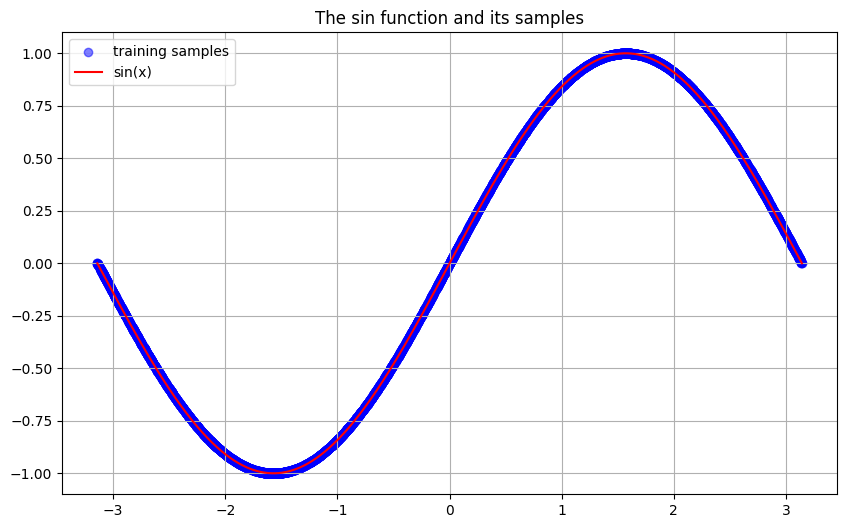

In [16]:
import numpy as np
np.random.seed(42)  # random seed

n_samples = 8000
x_train = np.random.uniform(-np.pi, np.pi, n_samples)
y_train = np.sin(x_train)

# test data
x_test = np.linspace(-np.pi, np.pi, 1000)
y_test = np.sin(x_test)

# save data
np.save('/mnt/workspace/AI/Week3-BP/data_train_x.npy', x_train)
np.save('/mnt/workspace/AI/Week3-BP/data_train_y.npy', y_train)
np.save('/mnt/workspace/AI/Week3-BP/data_test_x.npy', x_test)
np.save('/mnt/workspace/AI/Week3-BP/data_test_y.npy', y_test)

print('训练集大小:', x_train.shape)
print('测试集大小:', x_test.shape)

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, c='blue', alpha=0.5, label='training samples')
plt.plot(x_test, y_test, 'r-', label='sin(x)')
plt.title('The sin function and its samples')
plt.legend()
plt.grid(True)
plt.show()

## 手写神经网络实现
### Layer类
1. 随机初始化：`np.random.randn()` 生成服从标准正态分布(均值为0，方差为1)的随机数，避免所有权重相同导致的对称问题。
2. 缩放因子 `np.sqrt(2.0/input_dim)`：
- 防止梯度消失/爆炸：如果权重太大或太小，在深层网络中会导致梯度消失或爆炸
- 保持方差稳定：该缩放保证了每一层输出的方差大致相等
- 特别适合ReLU激活函数：系数`2.0`是针对ReLU激活函数特别优化的
3. 与输入维度相关：缩放因子与输入维度 `input_dim` 相关，这样可以自适应不同大小的层。
这种初始化方法由Kaiming He等人提出，被证明在使用ReLU激活函数的深度神经网络中特别有效。
### 反向传播
1. 前向传播：输入数据通过每一层，计算出最终的预测值。
2. 计算损失：使用损失函数计算预测值和真实值之间的误差（MSE）。
3. 从输出层开始反向传播：损失函数对输出层的梯度作为反向传播的起点。输出层计算权重和偏置的梯度，并将梯度传递给上一层。
4. 逐层反向传播：每一层根据传入的梯度计算自己的梯度，并将梯度传递给上一层。
5. 更新参数：使用梯度下降法更新每一层的权重和偏置。

In [17]:
import numpy as np

class Layer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0/input_dim)
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.output = None
        self.w_grad = None
        self.b_grad = None
    
    def forward(self, x):
        self.input = x
        self.output = np.dot(x, self.weights) + self.bias
        return self.output
    
    def backward(self, grad):

        self.w_grad = np.dot(self.input.T, grad)
        self.b_grad = np.sum(grad, axis=0, keepdims=True)
        return np.dot(grad, self.weights.T)
    
    def update(self, learning_rate):
        self.weights -= learning_rate * self.w_grad
        self.bias -= learning_rate * self.b_grad

class ReLU:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, x):
        self.input = x
        self.output = np.maximum(0, x)
        return self.output
    
    def backward(self, grad):
        return grad * (self.input > 0)
    
    def update(self, learning_rate):
        pass

class MSELoss:
    def __init__(self):
        self.diff = None
        
    def forward(self, pred, target):
        self.diff = pred - target
        return np.mean(np.square(self.diff))
    
    def backward(self):
        return 2 * self.diff / self.diff.shape[0]

class NeuralNetwork:
    def __init__(self):
        self.layers = [
            Layer(1, 32),
            ReLU(),
            Layer(32, 64),
            ReLU(),
            Layer(64, 32),
            ReLU(),
            Layer(32, 1)
        ]
        self.loss_fn = MSELoss()
        self.best_weights = None  # 存储最佳参数
        self.best_val_loss = float('inf')
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate)
    
    def train_step(self, x, y, learning_rate):
        # 前向传播
        pred = self.forward(x)
        loss = self.loss_fn.forward(pred, y)
        
        # 反向传播
        grad = self.loss_fn.backward()
        self.backward(grad)
        
        # 更新参数
        self.update(learning_rate)
        
        return loss
    
    def save_weights(self):
        self.best_weights = [(layer.weights.copy(), layer.bias.copy()) 
                            if isinstance(layer, Layer) else None
                            for layer in self.layers]
    
    def load_weights(self):
        for layer, weights in zip(self.layers, self.best_weights):
            if isinstance(layer, Layer) and weights is not None:
                layer.weights = weights[0].copy()
                layer.bias = weights[1].copy()
    
    def evaluate(self, x, y):
        predictions = self.predict(x)
        mse = np.mean(np.square(predictions - y.reshape(-1, 1)))
        return mse
    
    def train(self, x_train, y_train, x_val, y_val, epochs, batch_size=32, learning_rate=0.001):
        for epoch in range(epochs):
            # 随机打乱训练数据
            idx = np.random.permutation(len(x_train))
            x_train = x_train[idx]
            y_train = y_train[idx]
            
            total_loss = 0
            # 批量训练
            for i in range(0, len(x_train), batch_size):
                batch_x = x_train[i:i+batch_size].reshape(-1, 1)
                batch_y = y_train[i:i+batch_size].reshape(-1, 1)
                loss = self.train_step(batch_x, batch_y, learning_rate)
                total_loss += loss
            
            # 在验证集上评估
            val_loss = self.evaluate(x_val, y_val)
            
            # 保存最佳模型
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_weights()
            
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Train Loss: {total_loss/len(x_train):.6f}, Val Loss: {val_loss:.6f}')
    
    def predict(self, x):
        x = x.reshape(-1, 1)
        return self.forward(x)

Epoch 0, Train Loss: 0.033313, Val Loss: 0.145095
Epoch 100, Train Loss: 0.000005, Val Loss: 0.000124
Epoch 200, Train Loss: 0.000003, Val Loss: 0.000067
Epoch 300, Train Loss: 0.000003, Val Loss: 0.000044
Epoch 400, Train Loss: 0.000002, Val Loss: 0.000816
Epoch 500, Train Loss: 0.000001, Val Loss: 0.000028
Epoch 600, Train Loss: 0.000001, Val Loss: 0.000699
Epoch 700, Train Loss: 0.000001, Val Loss: 0.000025
Epoch 800, Train Loss: 0.000001, Val Loss: 0.000018
Epoch 900, Train Loss: 0.000001, Val Loss: 0.000018
Mean Squared Error: 2.2663521748861962e-05


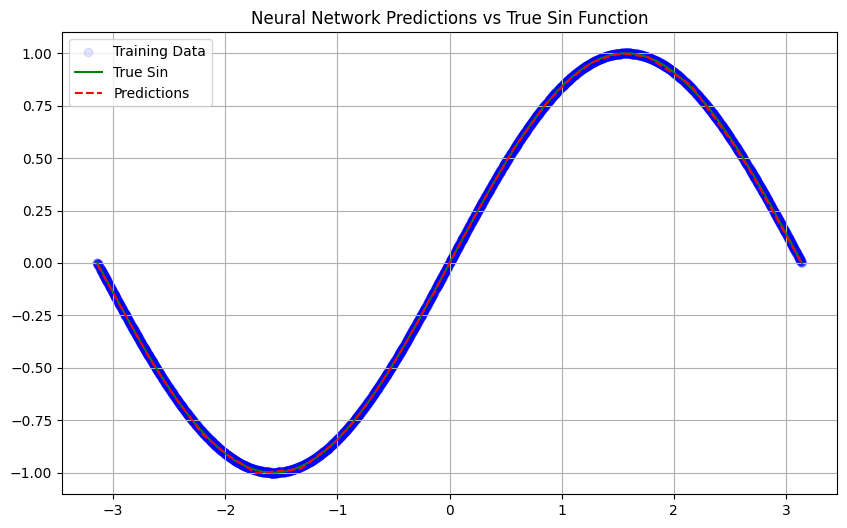

In [6]:
import matplotlib.pyplot as plt
# 加载数据
x_train = np.load('/mnt/workspace/AI/Week3-BP/data_train_x.npy')
y_train = np.load('/mnt/workspace/AI/Week3-BP/data_train_y.npy')
x_test = np.load('/mnt/workspace/AI/Week3-BP/data_test_x.npy')
y_test = np.load('/mnt/workspace/AI/Week3-BP/data_test_y.npy')

# 创建并训练神经网络
network = NeuralNetwork()
# 划分验证集
x_val, y_val = x_train[-100:], y_train[-100:]
x_train, y_train = x_train[:-100], y_train[:-100]
network.train(x_train, y_train, x_val, y_val, epochs=1000, batch_size=32 ,learning_rate=0.01)

# 预测并可视化结果
predictions = network.predict(x_test)
print(f'Mean Squared Error: {network.evaluate(x_test, y_test)}')

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, c='blue', alpha=0.1, label='Training Data')
plt.plot(x_test, y_test, 'g-', label='True Sin')
plt.plot(x_test, predictions, 'r--', label='Predictions')
plt.legend()
plt.title('Neural Network Predictions vs True Sin Function')
plt.grid(True)
plt.show()

## 手写数字识别

In [ ]:
import numpy as np
import struct
import os

def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

class Layer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0/input_dim)
        self.bias = np.zeros((1, output_dim))
    
    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, grad):
        self.w_grad = np.dot(self.input.T, grad)
        self.b_grad = np.sum(grad, axis=0, keepdims=True)
        return np.dot(grad, self.weights.T)
    
    def update(self, learning_rate):
        self.weights -= learning_rate * self.w_grad
        self.bias -= learning_rate * self.b_grad

class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad):
        return grad * (self.input > 0)
    
    def update(self, learning_rate):
        pass

class Softmax:
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def backward(self, grad):
        return grad

    def update(self, learning_rate):
        pass

class CrossEntropyLoss:
    def forward(self, pred, target):
        self.pred, self.target = pred, target
        return -np.sum(target * np.log(pred + 1e-7)) / pred.shape[0]
    
    def backward(self):
        return (self.pred - self.target) / self.pred.shape[0]

class NeuralNetwork:
    def __init__(self):
        self.layers = [
            Layer(784, 1024), ReLU(),
            Layer(1024, 512), ReLU(),
            Layer(512, 256), ReLU(),
            Layer(256, 10), Softmax()
        ]
        self.loss_fn = CrossEntropyLoss()
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate)
    
    def train_step(self, x, y, learning_rate):
        pred = self.forward(x)
        loss = self.loss_fn.forward(pred, y)
        self.backward(self.loss_fn.backward())
        self.update(learning_rate)
        return loss
    
    def predict(self, x):
        return np.argmax(self.forward(x), axis=1)
    
    def evaluate(self, x, y):
        return np.mean(self.predict(x) == y)

if __name__ == "__main__":
    X_train, y_train = load_mnist('train_data', kind='train')
    X_test, y_test = load_mnist('train_data', kind='t10k')
    X_train, X_test = X_train.astype(np.float32) / 255.0, X_test.astype(np.float32) / 255.0
    
    val_split = 0.2
    n_val = int(X_train.shape[0] * val_split)
    indices = np.random.permutation(X_train.shape[0])
    X_val, y_val = X_train[indices[:n_val]], y_train[indices[:n_val]]
    X_train, y_train = X_train[indices[n_val:]], y_train[indices[n_val:]]
    
    y_train_onehot = np.eye(10)[y_train]
    y_val_onehot = np.eye(10)[y_val]
    
    network = NeuralNetwork()
    batch_size, epochs, learning_rate = 128, 50, 0.01
    n_batches = X_train.shape[0] // batch_size
    
    patience, best_loss, patience_counter = 5, float('inf'), 0
    best_model = None
    
    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_batches):
            batch_x = X_train[i * batch_size:(i + 1) * batch_size]
            batch_y = y_train_onehot[i * batch_size:(i + 1) * batch_size]
            total_loss += network.train_step(batch_x, batch_y, learning_rate)
        
        train_acc = network.evaluate(X_train, y_train)
        val_acc = network.evaluate(X_val, y_val)
        val_loss = network.loss_fn.forward(network.forward(X_val), y_val_onehot)
        
        print(f'Epoch {epoch + 1}: Loss {total_loss / n_batches:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}')
        
        if val_loss < best_loss:
            best_loss, patience_counter = val_loss, 0
            best_model = network
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    test_acc = best_model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_acc:.4f}')


Epoch 1: Loss 0.8473, Train Acc 0.8908, Val Acc 0.8912
Epoch 2: Loss 0.3589, Train Acc 0.9133, Val Acc 0.9146
Epoch 3: Loss 0.2922, Train Acc 0.9249, Val Acc 0.9264
Epoch 4: Loss 0.2571, Train Acc 0.9324, Val Acc 0.9314
Epoch 5: Loss 0.2326, Train Acc 0.9384, Val Acc 0.9365
Epoch 6: Loss 0.2134, Train Acc 0.9432, Val Acc 0.9420
Epoch 7: Loss 0.1975, Train Acc 0.9477, Val Acc 0.9456
Epoch 8: Loss 0.1840, Train Acc 0.9510, Val Acc 0.9479
Epoch 9: Loss 0.1722, Train Acc 0.9537, Val Acc 0.9500
Epoch 10: Loss 0.1617, Train Acc 0.9568, Val Acc 0.9520
Epoch 11: Loss 0.1524, Train Acc 0.9589, Val Acc 0.9537
Epoch 12: Loss 0.1439, Train Acc 0.9610, Val Acc 0.9553
Epoch 13: Loss 0.1363, Train Acc 0.9633, Val Acc 0.9568
Epoch 14: Loss 0.1293, Train Acc 0.9654, Val Acc 0.9577
Epoch 15: Loss 0.1230, Train Acc 0.9671, Val Acc 0.9584
Epoch 16: Loss 0.1171, Train Acc 0.9690, Val Acc 0.9599
Epoch 17: Loss 0.1117, Train Acc 0.9707, Val Acc 0.9617
Epoch 18: Loss 0.1066, Train Acc 0.9723, Val Acc 0.9625
E

In [13]:
test_acc = network.evaluate(X_test, y_test)
print('test_acc:', test_acc)

test_acc: 0.9762


## 网络结构对比实验

比较以下几种配置：
1. 不同层数的网络
2. 不同神经元数量的网络
3. 不同学习率的效果
4. 不同批量大小的效果

Detailed Results:

shallow:
Test Loss: 0.000074

medium:
Test Loss: 0.000076

deep:
Test Loss: 0.000036

wide:
Test Loss: 0.025140


Training shallow...
Epoch 0, Train Loss: 0.008059, Val Loss: 0.181029
Epoch 100, Train Loss: 0.000006, Val Loss: 0.000146
Epoch 200, Train Loss: 0.000002, Val Loss: 0.000058
Epoch 300, Train Loss: 0.000002, Val Loss: 0.000050
Epoch 400, Train Loss: 0.000002, Val Loss: 0.000076
Epoch 500, Train Loss: 0.000002, Val Loss: 0.000102
Epoch 600, Train Loss: 0.000002, Val Loss: 0.000058
Epoch 700, Train Loss: 0.000002, Val Loss: 0.000051
Epoch 800, Train Loss: 0.000002, Val Loss: 0.000051
Epoch 900, Train Loss: 0.000002, Val Loss: 0.000047

Training medium...
Epoch 0, Train Loss: 0.006487, Val Loss: 0.150926
Epoch 100, Train Loss: 0.000005, Val Loss: 0.000094
Epoch 200, Train Loss: 0.000004, Val Loss: 0.000099
Epoch 300, Train Loss: 0.000004, Val Loss: 0.000065
Epoch 400, Train Loss: 0.000006, Val Loss: 0.000063
Epoch 500, Train Loss: 0.000002, Val Loss: 0.000086
Epoch 600, Train Loss: 0.000003, Val Loss: 0.000079
Epoch 700, Train Loss: 0.000002, Val Loss: 0.000093
Epoch 800, Train Loss: 0.00

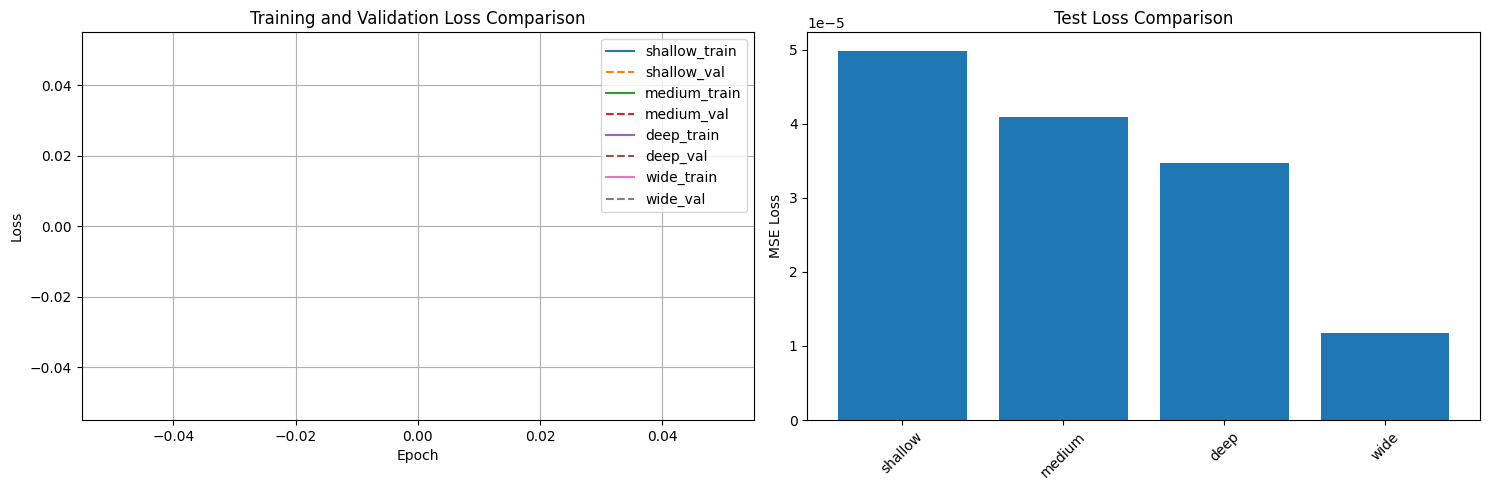


Detailed Results:

shallow:
Test Loss: 0.000050

medium:
Test Loss: 0.000041

deep:
Test Loss: 0.000035

wide:
Test Loss: 0.000012


In [19]:
class NeuralNetworkFactory:
    @staticmethod
    def create_network(structure, learning_rate=0.01):
        layers = []
        for i in range(len(structure)-1):
            layers.append(Layer(structure[i], structure[i+1]))
            if i < len(structure)-2:
                layers.append(ReLU())
        return layers

class ConfigurableNeuralNetwork(NeuralNetwork):
    def __init__(self, structure):
        self.layers = NeuralNetworkFactory.create_network(structure)
        self.loss_fn = MSELoss()
        self.best_weights = None
        self.best_val_loss = float('inf')
        self.training_history = {'train_loss': [], 'val_loss': []}

def run_experiment(x_train, y_train, x_val, y_val, x_test, y_test, configs):
    results = {}
    
    for name, config in configs.items():
        print(f'\nTraining {name}...')
        network = ConfigurableNeuralNetwork(config['structure'])
        network.train(x_train, y_train, x_val, y_val, 
                     epochs=config['epochs'],
                     batch_size=config['batch_size'],
                     learning_rate=config['learning_rate'])
    
        network.load_weights()
        test_loss = network.evaluate(x_test, y_test)
        results[name] = {
            'test_loss': test_loss,
            'training_history': network.training_history
        }
    return results

# 定义不同的网络配置
network_configs = {
    'shallow': {
        'structure': [1, 32, 1],
        'epochs': 1000,
        'batch_size': 32,
        'learning_rate': 0.01
    },
    'medium': {
        'structure': [1, 32, 16, 1],
        'epochs': 1000,
        'batch_size': 32,
        'learning_rate': 0.01
    },
    'deep': {
        'structure': [1, 64, 32, 16, 1],
        'epochs': 1000,
        'batch_size': 32,
        'learning_rate': 0.01
    },
    'wide': {
        'structure': [1, 128, 128, 1],
        'epochs': 1000,
        'batch_size': 32,
        'learning_rate': 0.01
    }
}

# 运行实验
x_train = np.load('/mnt/workspace/AI/Week3-BP/data_train_x.npy')
y_train = np.load('/mnt/workspace/AI/Week3-BP/data_train_y.npy')
x_test = np.load('/mnt/workspace/AI/Week3-BP/data_test_x.npy')
y_test = np.load('/mnt/workspace/AI/Week3-BP/data_test_y.npy')

# 划分验证集
x_val, y_val = x_train[-100:], y_train[-100:]
x_train, y_train = x_train[:-100], y_train[:-100]
results = run_experiment(x_train, y_train, x_val, y_val, x_test, y_test, network_configs)

# 可视化比较结果
plt.figure(figsize=(15, 5))

# 绘制损失曲线对比
plt.subplot(1, 2, 1)
for name, result in results.items():
    plt.plot(result['training_history']['train_loss'], label=f'{name}_train')
    plt.plot(result['training_history']['val_loss'], '--', label=f'{name}_val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.grid(True)

# 绘制最终测试结果对比
plt.subplot(1, 2, 2)
names = list(results.keys())
test_losses = [results[name]['test_loss'] for name in names]
plt.bar(names, test_losses)
plt.title('Test Loss Comparison')
plt.ylabel('MSE Loss')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 打印详细结果
print('\nDetailed Results:')
for name, result in results.items():
    print(f'\n{name}:')
    print(f'Test Loss: {result["test_loss"]:.6f}')